## Testing the halo_run catalog
#### Zhuowen Zhang; Created Oct. 10, 2018

Testing properties of the halo_run catalog and comparing it with the Chinchilla_unique catalog. 

### Initial setup

In [3]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

### Importing Halo Files

#### Halo_Run Catalog

In [70]:
from tools.setup.setup import data_home_dir, home_dir
import pyfits
datadir = data_home_dir()
hrun_dir = datadir + 'halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto.fit'
hrun_list = pyfits.open(hrun_dir)
hrun_data = hrun_list[1].data

hrun_haloID = hrun_data['HALOID']; hrun_redMID = hrun_data['MEM_MATCH_ID']
hrun_lmda = hrun_data['LAMBDA_CHISQ']; \
hrun_z = hrun_data['Z']; hrun_RA = hrun_data['RA']; hrun_DEC = hrun_data['DEC']; \
hrun_M200 = hrun_data['M200']; hrun_R200 = hrun_data['R200']

print "Number of halos is", len(hrun_data)
#print hrun_data.columns

Number of halos is 124403


#### redMaPPer matched halos from Chinchilla

In [71]:
homedir = home_dir()
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Import parameters from halo_redM_matched
redM_ID, redM_RA, redM_DEC, redM_z, redM_lmda, \
        halos_matched_ID, halos_matched_RA, halos_matched_DEC, halos_matched_z, \
        halos_matched_X, halos_matched_Y, halos_matched_Z, halos_matched_M, halos_matched_Rvir = \
        np.loadtxt(redM_dir, dtype ="i, f, f, f, f, i, f, f, f, f, f, f, f, f", \
                     unpack=True, usecols=range(0,14), skiprows=1)

### Comparing halo_run vs. halo_redM_matched

#### Build fiducial cosmology for calc. comoving distance and other cosmological metrics

In [33]:
#Distance calculations for proximity matching
from colossus.cosmology import cosmology

#Conform to Buzzard cosmology
h = 0.70
my_cosmo = {'flat': True, 'H0': h*100, 'Om0': 0.286, 'Ob0': 0.045714, 'sigma8': 0.82, \
            'ns': 0.951, 'Neff':3.04}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)   

#Set to transverse or line of sight comoving distance? Can't tell. 
#comoving_r = cosmo.comovingDistance(zmin, zmax, transverse=True)

#### Sanity check: All halos in halo_redM_matched should be in halo_run

In [53]:
halos_matched_bool = np.isin(halos_matched_ID,  halos_hrun_haloID)
redM_matched_bool = np.isin(redM_ID, halos_hrun_redMID)
halocut = np.where(halos_matched_bool == True)[0]
clcut = np.where(redM_matched_bool == True)[0]
print "Number of matched_halos in hrun is ", len(halocut), "out of ", len(halos_matched_ID)
print "Number of clusters in hrun is ", len(clcut), "out of ", len(redM_ID)

Number of matched_halos in hrun is  19165 out of  23997
Number of clusters in hrun is  21545 out of  23997


#### Apply cuts
e.g. for matched_halos found in halo_run; or for clusters with MEM_MATCH_ID found in halo_run

In [59]:
#for matched_halos with IDs also found in halo-run
redM_lmda_halocut = redM_lmda[halocut]
redM_RA_halocut = redM_RA[halocut] 
redM_DEC_halocut = redM_DEC[halocut]
halos_matched_RA_halocut = halos_matched_RA[halocut]
halos_matched_DEC_halocut = halos_matched_DEC[halocut]
halos_matched_z_halocut = halos_matched_z[halocut]

#for matched_halos with MEM_MATCH_ID cluster IDs also found in halo_run
redM_lmda_clcut = redM_lmda[clcut]
redM_RA_clcut = redM_RA[clcut] 
redM_DEC_clcut = redM_DEC[clcut]
halos_matched_RA_clcut = halos_matched_RA[clcut]
halos_matched_DEC_clcut = halos_matched_DEC[clcut]
halos_matched_z_clcut = halos_matched_z[clcut]

#### Cluster miscentering from matched halos

In [60]:
#Find comoving distance to observer
redM_comvr = cosmo.comovingDistance(0.0,redM_z)
halos_matched_comvr = cosmo.comovingDistance(0.0, halos_matched_z)
halos_matched_comvr_halocut = cosmo.comovingDistance(0.0, halos_matched_z_halocut) 

#Angle difference from RA, DEC using law of cosines
d_RA = redM_RA - halos_matched_RA
cos_theta = np.sin(redM_DEC)*np.sin(halos_matched_DEC)+\
            np.cos(redM_DEC)*np.cos(halos_matched_DEC)*np.cos(d_RA)
    
d_RA_halocut = redM_RA_halocut - halos_matched_RA_halocut
cos_theta_halocut = np.sin(redM_DEC_halocut)*np.sin(halos_matched_DEC_halocut)+\
            np.cos(redM_DEC_halocut)*np.cos(halos_matched_DEC_halocut)*np.cos(d_RA_halocut)
    
#comoving distance between halo and clusters from law of cosines
#find projected comving distance using redshift of the center halo. 
d_cmvr = np.sqrt(2*halos_matched_comvr**2. * (1-cos_theta))
d_cmvr_halocut = np.sqrt(2*halos_matched_comvr_halocut**2. * (1-cos_theta_halocut))
#d_cmvr = np.sqrt(halos_matched_comvr**2. + redM_comvr**2. - 2*redM_comvr*halos_matched_comvr*cos_theta)

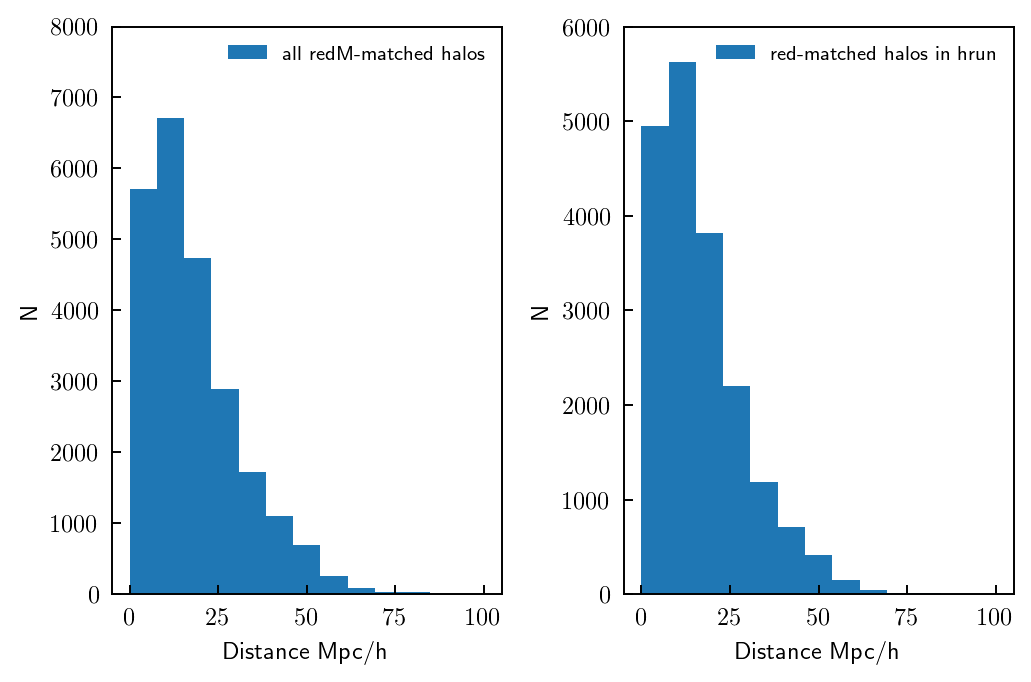

In [69]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bin=13;
hist_range = (0,100)

#Plotting random halos
axs[0].hist(d_cmvr, num_bin, range=hist_range, label='all redM-matched halos')
axs[1].hist(d_cmvr_halocut, num_bin, range=hist_range, label='red-matched halos in hrun')

#Plot config   
axs[0].set_ylim((0,8000))
axs[0].set_xlabel('Distance Mpc/h')
axs[0].set_ylabel('N')
#axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)
axs[0].legend(loc='best', fontsize=8, frameon=False)

axs[1].set_ylim((0,6000))
axs[1].set_xlabel(r'Distance Mpc/h')
axs[1].set_ylabel('N')
#axs[1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
axs[1].legend(loc='best', fontsize=8, frameon=False)
#plt.savefig('ellipticity_032018.png')
plt.show()

#### !TODO!
Match hrun_lmda to redM_lmda. See scatter plot. Should be in theory a line if no bias. 

In [81]:
cut = np.where(np.isin(hrun_haloID, halos_matched_ID)==True)
hrun_haloID_cut = hrun_haloID[cut]
hrun_haloID_cut = np.unique(hrun_haloID_cut)

#hrun_lmda_cut = hrun_lmda[cut]
#hrun_lmda_cut = np.unique(hrun_lmda_cut)
print len(hrun_haloID_cut)
print len(hrun_lmda_cut), len(redM_lmda_halocut)

lmda_a = []
lmda_b = []
for i, cur_ID in enumerate(hrun_haloID_cut):
    if i %10000 == 0: print i
    ind_a = np.where(hrun_haloID_cut)    
        
    if np.isin(cur_ID, hrun_haloID):
        ind = np.where(hrun_haloID == cur_ID)[0]
        lmda_a.append(redM_lmda[i])
        lmda_b.append(ind[0])

        

#plt.scatter(lmda_a, lmda_b, s=0.1)
#plt.show()

19165
4379 19165


'\nfor i, cur_ID in enumerate(halos_matched_ID):\n    if i %10000 == 0: print i\n    if np.isin(cur_ID, hrun_haloID):\n        ind = np.where(hrun_haloID == cur_ID)[0]\n        lmda_a.append(redM_lmda[i])\n        lmda_b.append(ind[0])\n'